In [9]:
!pip install -q ../introdl/

In [1]:
# imports and configuration

# uncomment to use a custom environment file
# from dotenv import load_dotenv
# load_dotenv('../main.env')

import os
from pathlib import Path

MODELS_PATH = Path(os.getenv('MODELS_PATH'))
DATA_PATH = Path(os.getenv('DATA_PATH'))
TORCH_HOME = Path(os.getenv('TORCH_HOME'))

print(f'{MODELS_PATH=}')
print(f'{DATA_PATH=}')
print(f'{TORCH_HOME=}')

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import OneCycleLR

import torchvision.transforms.v2 as T

from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

from introdl.utils import get_device, load_results, summarizer
from introdl.idlmam import train_network
from introdl.visul import plot_training_metrics, image_to_PIL, plot_transformed_images

sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = [8, 6]  # Set the default figure size (width, height) in inches

MODELS_PATH=WindowsPath('C:/Users/bagge/My Drive/Python_Projects/DS776_Develop_Project/models')
DATA_PATH=WindowsPath('C:/Users/bagge/My Drive/Python_Projects/DS776_Develop_Project/data')
TORCH_HOME=WindowsPath('C:/Users/bagge/My Drive/Python_Projects/DS776_Develop_Project/downloads')


In [2]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform_train = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Resize((256,256)),
    T.RandomRotation(degrees=15),
    T.RandomCrop(224),
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.RandomGrayscale(),
    T.Normalize(mean=mean, std=std), 
    T.ToPureTensor()   
])

transform_val = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Resize((224,224)),
    T.Normalize(mean=mean, std=std),
    T.ToPureTensor()   
])

In [3]:
full_train_dataset = ImageFolder(DATA_PATH / 'cats_dogs_foxes',transform=transform_train)
full_val_dataset = ImageFolder(DATA_PATH / 'cats_dogs_foxes', transform=transform_val)
train_indices, val_indices = train_test_split(list(range(len(full_train_dataset))), train_size=0.8, random_state=42)

train_dataset = Subset(full_train_dataset, train_indices)
val_dataset = Subset(full_val_dataset, val_indices)

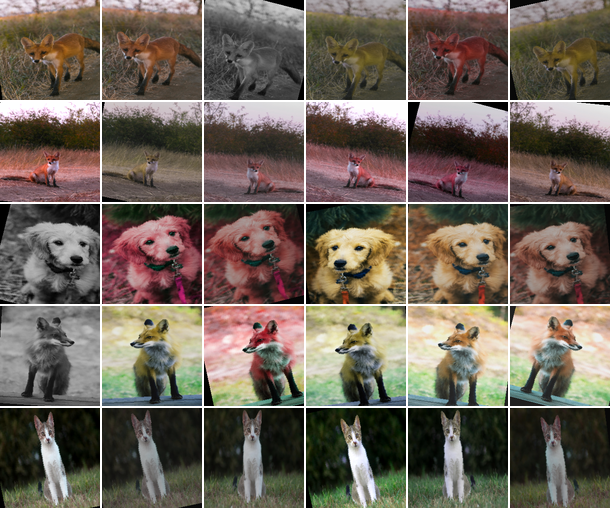

In [4]:
plot_transformed_images(train_dataset, img_size=(100,100), mean=mean, std=std)

In [4]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

In [20]:
# Load the pre-trained model with new API
model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)
model

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to C:\Users\bagge\My Drive\Python_Projects\DS776_Develop_Project\downloads\hub\checkpoints\mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 22.4MB/s]


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [21]:
# Change the number of output classes to 3
model.classifier[-1] = torch.nn.Linear(model.classifier[-1].in_features, 3)

# Freeze all layers except the classifier
for param in model.features.parameters():
    param.requires_grad = False

In [25]:
loss_func = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.AdamW(model.parameters())  # Adam optimizer

device = get_device()
print(device)

ckpt_file = MODELS_PATH / 'L05_frozen_backbone_mnv3.pt'
epochs = 3

score_funcs = {'ACC':accuracy_score}

cuda


In [26]:
results = train_network(model,
                        loss_func,
                        train_loader,
                        device=device,
                        val_loader=val_loader,
                        epochs = epochs,
                        optimizer = optimizer,
                        score_funcs = score_funcs,
                        checkpoint_file=ckpt_file,
                        resume_checkpoint=False)

Epoch: 100%|██████████| 3/3 [01:26<00:00, 28.89s/it, train_loss=0.291, val_loss=0.355]


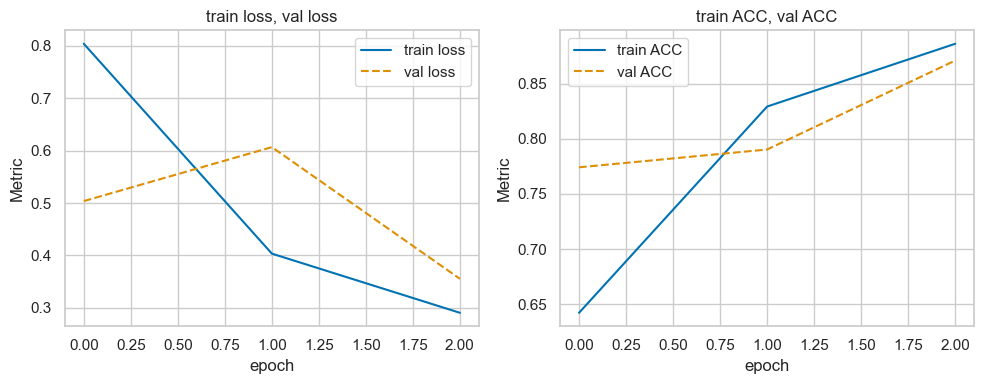

In [27]:
ckpt_file = MODELS_PATH / 'L05_frozen_backbone_mnv3.pt'
AdamW_augment = load_results(ckpt_file)

plot_training_metrics(AdamW_augment, [['train loss', 'val loss'], ['train ACC', 'val ACC']])

In [28]:
# Unfreeze all layers
for param in model.features.parameters():
    param.requires_grad = False

In [29]:
resume_file = MODELS_PATH / 'L05_frozen_backbone_mnv3.pt'
ckpt_file = MODELS_PATH / 'L05_unfrozen_backbone_mnv3.pt'
epochs = 5
results = train_network(model,
                        loss_func,
                        train_loader,
                        device=device,
                        val_loader=val_loader,
                        epochs = epochs,
                        optimizer = optimizer,
                        score_funcs = score_funcs,
                        checkpoint_file=ckpt_file,
                        resume_file=resume_file)

Epoch: 100%|██████████| 5/5 [02:29<00:00, 29.95s/it, train_loss=0.112, val_loss=0.285]


In [19]:
ckpt_file = MODELS_PATH / 'L05_unfrozen_backbone_mnv3.pt'
results = load_results(ckpt_file)
results

,epoch,total time,train loss,val loss,train ACC,val ACC
0,0,18.373462,0.804077,0.503820,0.642276,0.774194
1,1,38.086253,0.403500,0.606781,0.829268,0.790323
2,2,57.451689,0.290554,0.355387,0.886179,0.870968
3,3,75.817874,0.247761,0.326293,0.898374,0.870968
4,4,94.969382,0.150503,0.401392,0.951220,0.870968
5,5,115.506882,0.126059,0.258075,0.959350,0.887097
6,6,137.101621,0.122768,0.297200,0.963415,0.903226
7,7,157.103895,0.112260,0.285370,0.963415,0.887097


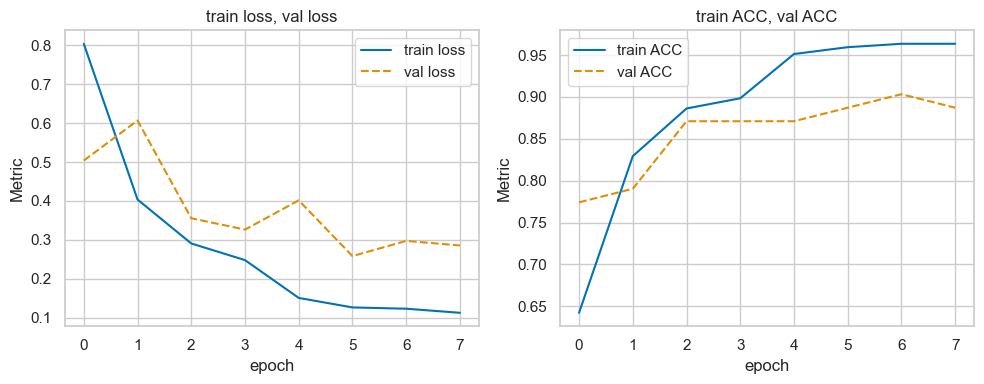

In [30]:
ckpt_file = MODELS_PATH / 'L05_unfrozen_backbone_mnv3.pt'
AdamW_augment = load_results(ckpt_file)

plot_training_metrics(AdamW_augment, [['train loss', 'val loss'], ['train ACC', 'val ACC']])

In [15]:
model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)
loss_func = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.AdamW(model.parameters())  # Adam optimizer
max_lr = 1e-3
epochs = 5
scheduler = OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

device = get_device()
print(device)

ckpt_file = MODELS_PATH / 'L05_fine_tune_mnv3.pt'
score_funcs = {'ACC':accuracy_score}

cuda


In [16]:
results = train_network(model,
                        loss_func,
                        train_loader,
                        device=device,
                        val_loader=val_loader,
                        epochs = epochs,
                        optimizer = optimizer,
                        score_funcs = score_funcs,
                        checkpoint_file=ckpt_file,
                        lr_schedule=scheduler,
                        scheduler_step_per_batch=True)

Epoch: 100%|██████████| 5/5 [02:26<00:00, 29.36s/it, train_loss=0.0905, val_loss=0.495]


In [18]:
results

,epoch,total time,train loss,val loss,train ACC,val ACC,lr
0,0,18.054046,9.035636,4.295771,0.024390,0.129032,0.000834
1,1,38.023712,0.984805,0.722963,0.682927,0.822581,0.000923
2,2,58.415811,0.264539,0.479182,0.906504,0.854839,0.000556
3,3,77.506018,0.107809,0.492635,0.951220,0.854839,0.000146
4,4,96.135039,0.090465,0.494502,0.967480,0.838710,0.000003


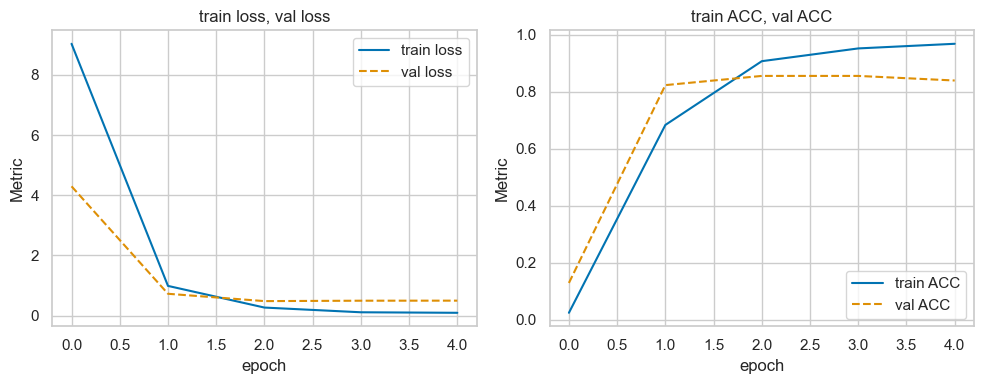

In [17]:
ckpt_file = MODELS_PATH / 'L05_fine_tune_mnv3.pt'
AdamW_augment = load_results(ckpt_file)

plot_training_metrics(AdamW_augment, [['train loss', 'val loss'], ['train ACC', 'val ACC']])